# Title

Summary

# Introduction

# Methods and Results

### Exploratory Data Analysis

First, we load and tidy the data by removing the non-numeric columns, `month` and `date`, and the numeric columns, `X` (x-axis coordinates) and `Y` (y-axis coordinates), as they are not useful in our analysis.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(tidymodels)
    library(GGally)
})
options(repr.plot.width = 15, repr.plot.height = 12)

In [2]:
fire_data <- read_csv("data/forestfires.csv", show_col_types = FALSE)
fire_data <- fire_data %>% select(-X, -Y, -month, -day)
"Table 1: Tidied Data"
head(fire_data)

[1] "Table 1: Tidied Data"

FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


The variables are defined as:
- `FFMC`: FFMC index from the FWI system: 18.7 to 96.20
- `DMC`: DMC index from the FWI system: 1.1 to 291.3
- `DC`: DC index from the FWI system: 7.9 to 860.6
- `ISI`: ISI index from the FWI system: 0.0 to 56.10
- `temp`: temperature in Celsius degrees: 2.2 to 33.30
- `RH`: relative humidity in %: 15.0 to 100
- `wind`: wind speed in km/h: 0.40 to 9.40
- `rain`: outside rain in mm/m2 : 0.0 to 6.4
- `area`: the burned area of the forest (in ha): 0.00 to 1090.84 

Now, we split the data into a 75:25 training and testing split, which is then scaled and centered to ensure that all variables are on a comparable scale.

In [3]:
set.seed(2022)
fire_split <- initial_split(fire_data, prop = 0.75, strata = area)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

fire_recipe <- recipe(area ~ . , data = fire_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

fire_scaled <- fire_recipe %>%
            prep() %>%
            bake(fire_train)

Then, we plot a correlation matrix to determine if any pairs of variables are associated with each other.

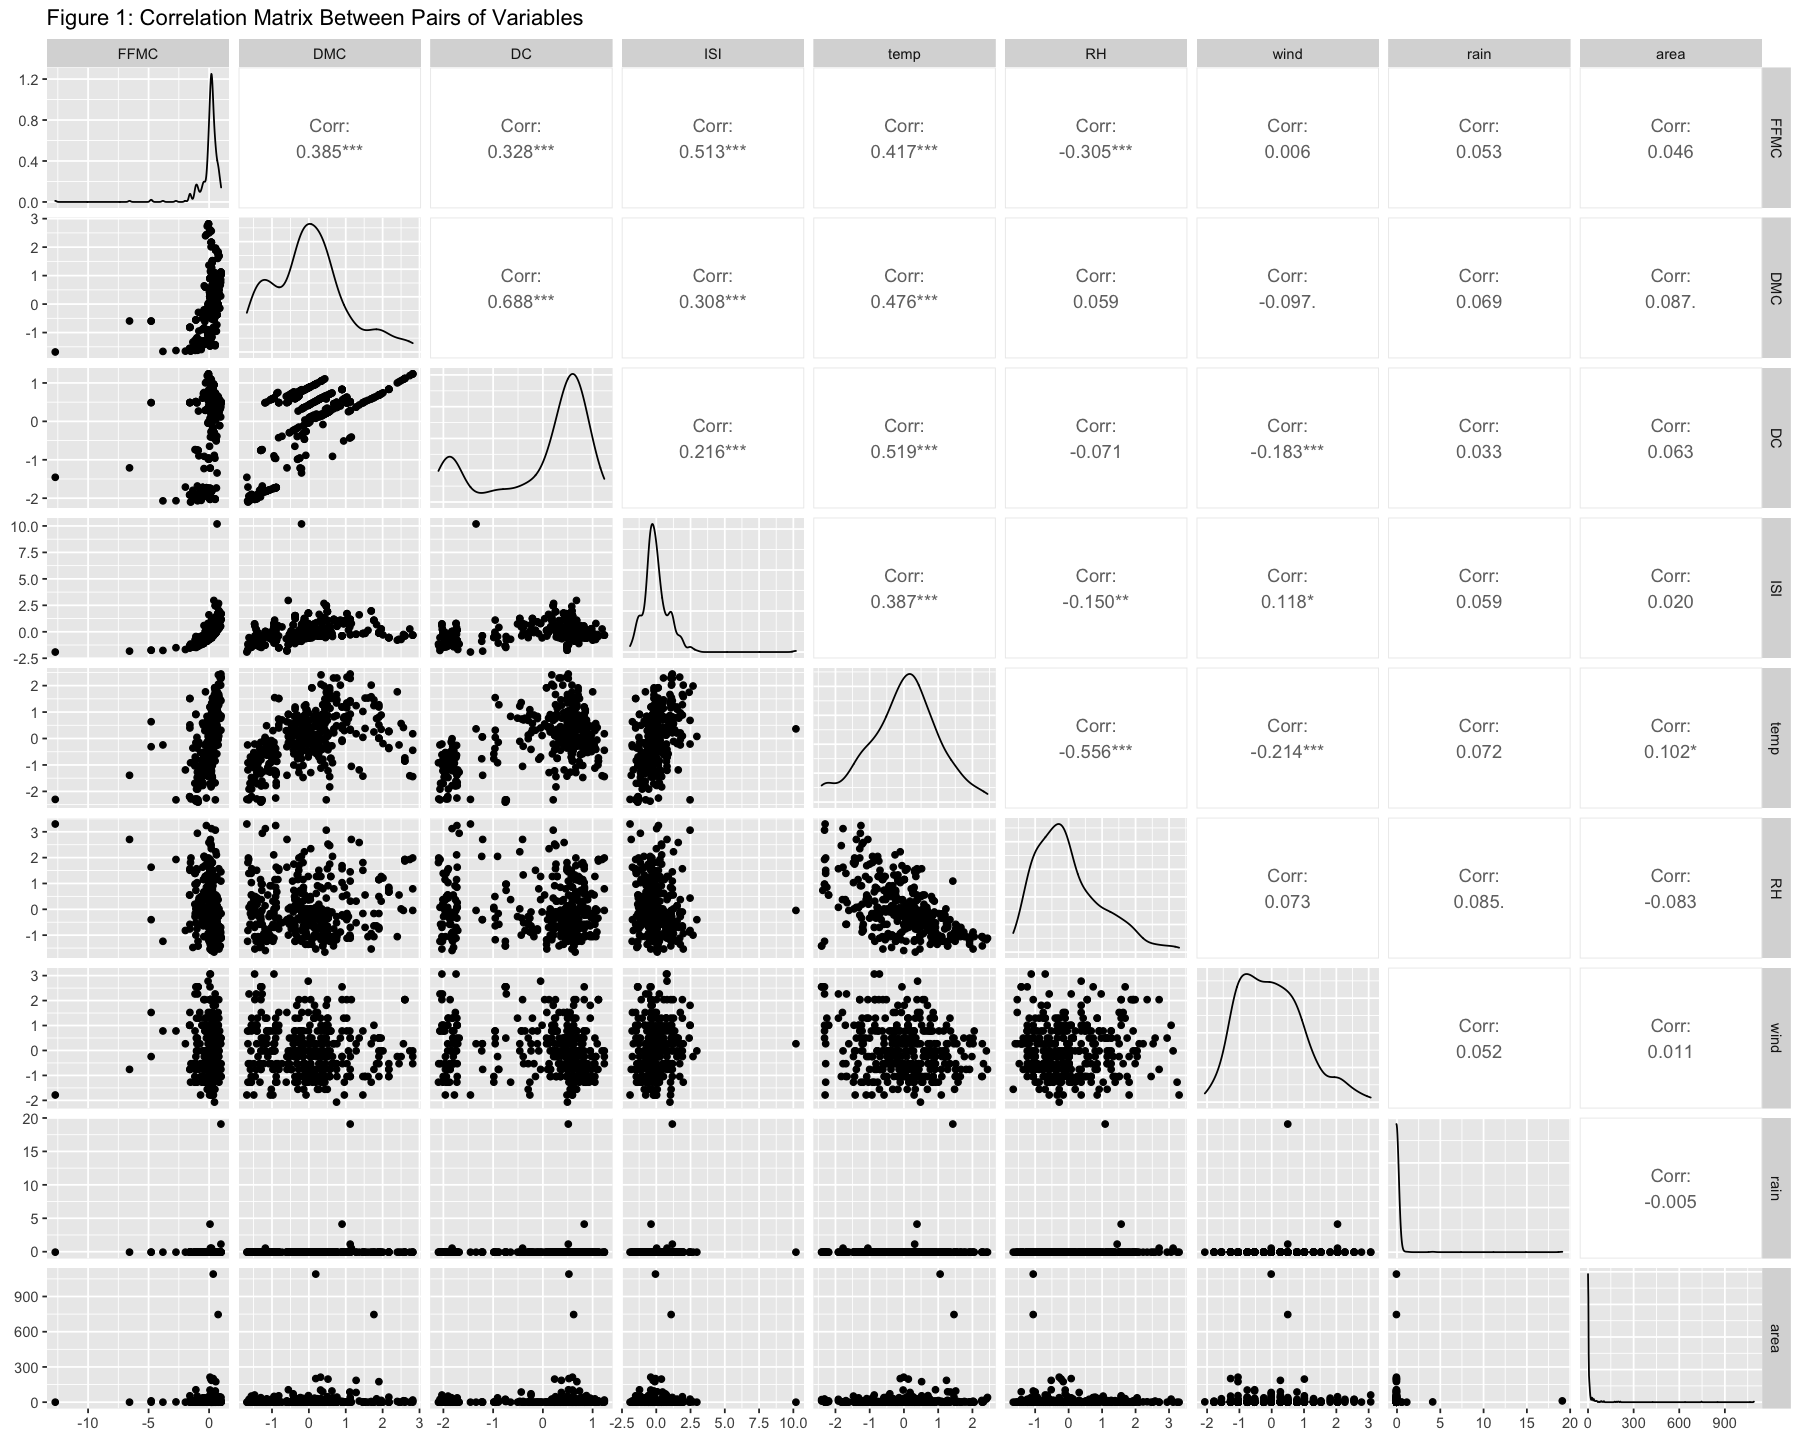

In [4]:
ggpairs(fire_scaled) +
    ggtitle("Figure 1: Correlation Matrix Between Pairs of Variables")

From Figure 1, we see that `DC` and `DMC`; `ISI` and `FFMC`; `temp` and `DMC`; `temp` and `DC`; and `RH` and `temp` have quite large correlation values. So, we will create another correlation matrix with only those variables to examine them closer.

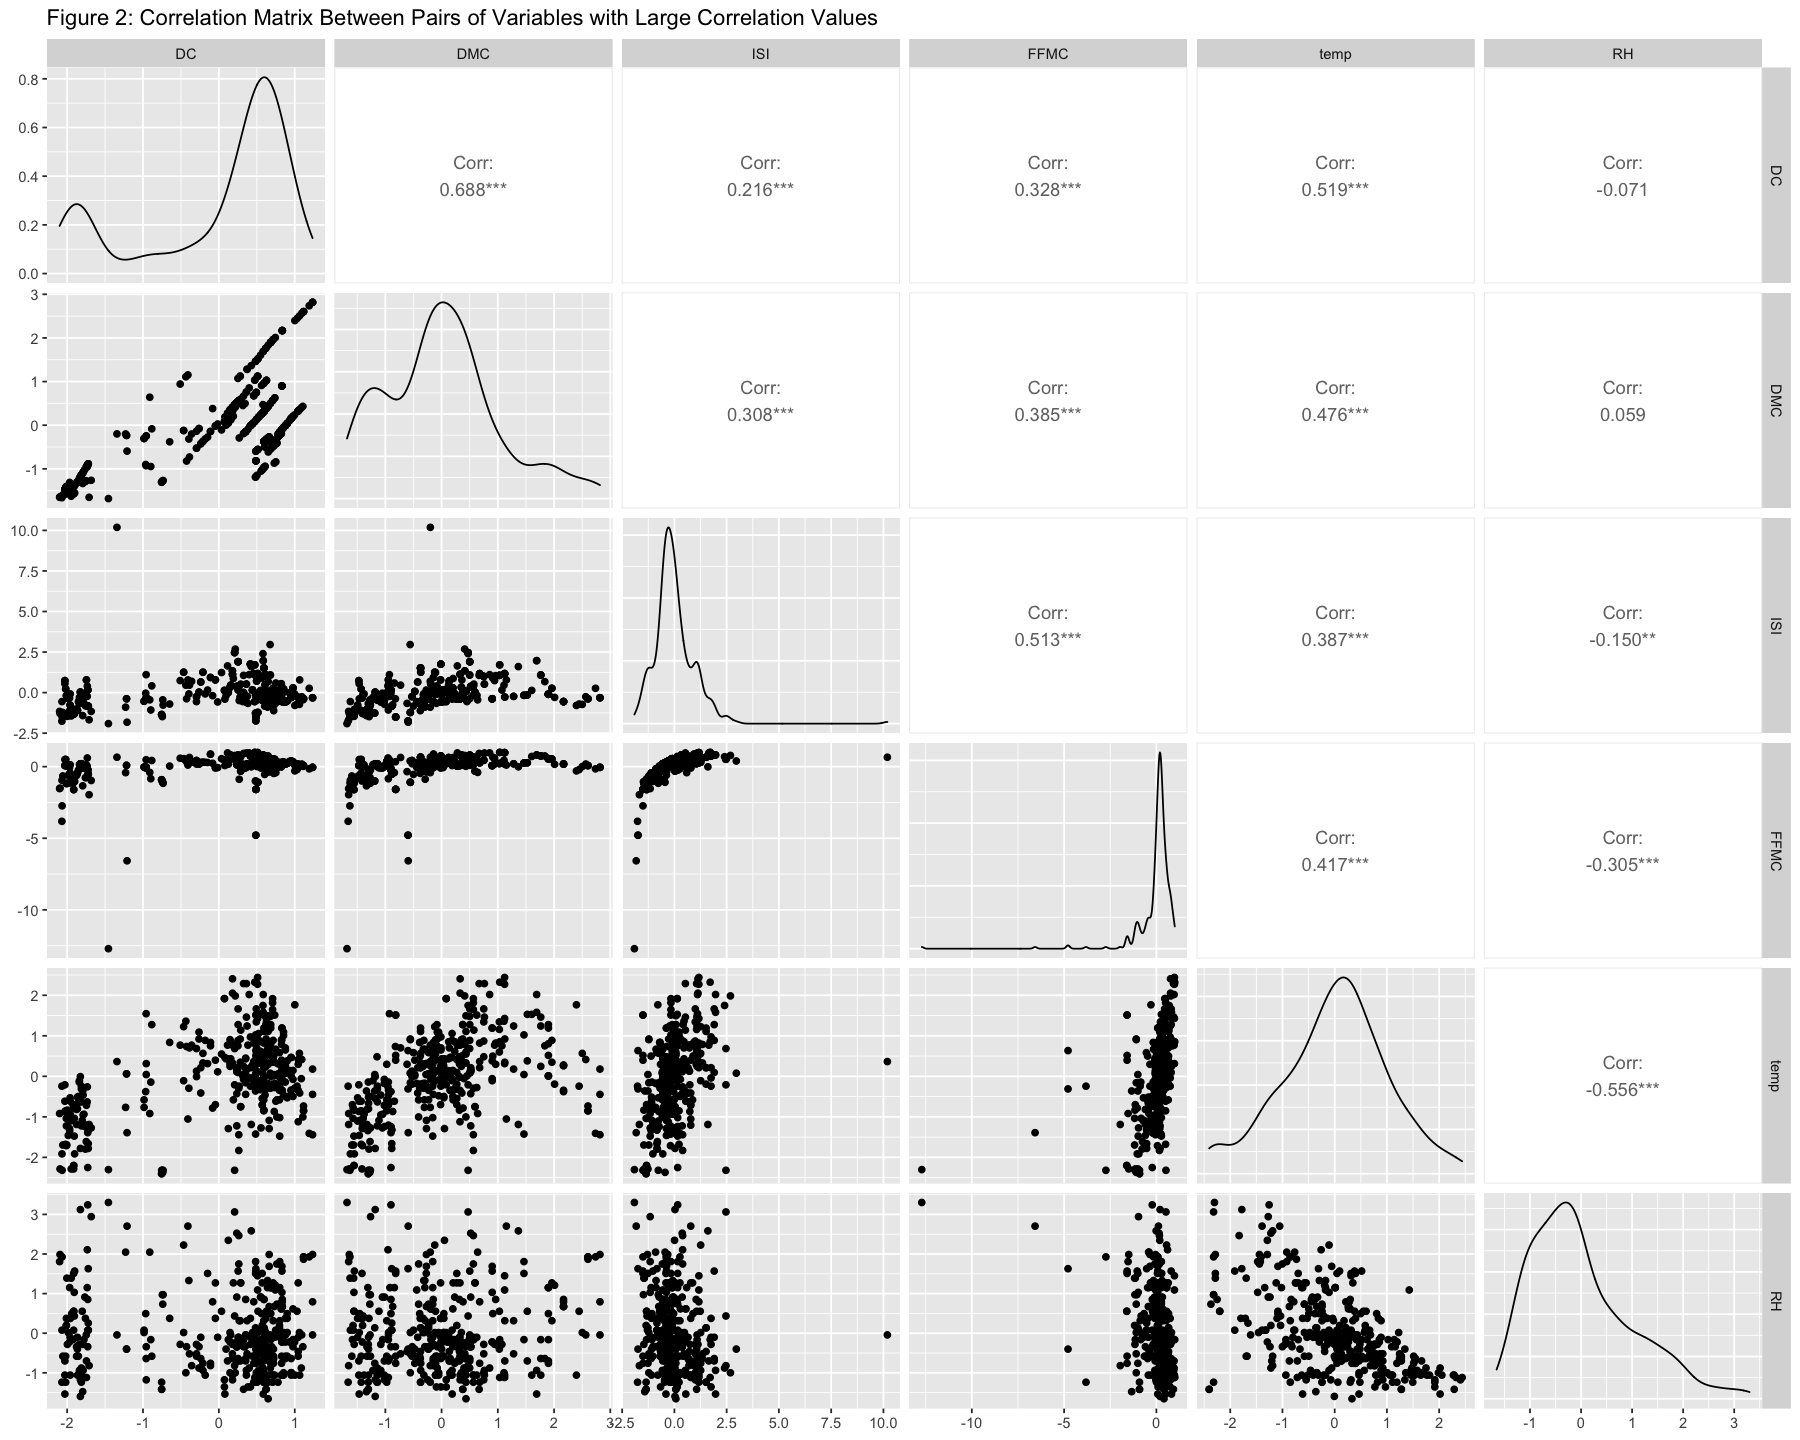

In [5]:
cor_data <- fire_scaled %>% select(DC, DMC, ISI, FFMC, temp, RH)
ggpairs(cor_data) +
    ggtitle("Figure 2: Correlation Matrix Between Pairs of Variables with Large Correlation Values")

Looking at the scatter plots with evident trends, for `DC` and `DMC`, there appears to be a strong, positive relationship between the variables; whereas for temperature (`temp`) and relative humidity (`RH`), there appears to be a weak, negative relationship. And for `ISI` and `FFMC`, the plot follows a logarithmic curve, with a majority of the points concentrated around `ISI` values of -1.25 to 1.25.

### Finding the best $k$

In order to build our $k$-NN regression model, we use the aforementioned variables and perform cross-validation with 5 folds to find the number of neighbours with the minimum RMSE (root mean square error).

In [6]:
fire_recipe <- recipe(area ~ DC + DMC + ISI + FFMC + temp + RH, data = fire_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("regression")

fire_cv <- vfold_cv(fire_train, v = 5, strata = area)

fire_wkflw <- workflow() %>%
            add_recipe(fire_recipe) %>%
            add_model(fire_spec) 

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

fire_results <- fire_wkflw %>%
            tune_grid(resamples = fire_cv, grid = gridvals) %>%
            collect_metrics() %>%
            filter(.metric == "rmse")

min_rmse <- fire_results %>%
            filter(mean == min(mean))

k_min <- min_rmse %>%
        pull(neighbors)

"Table 2: The Number of Neighbors with the Minimum RMSE"
min_rmse

[1] "Table 2: The Number of Neighbors with the Minimum RMSE"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
142,rmse,standard,59.01036,5,19.70003,Preprocessor1_Model48


We see that the smallest RMSE is when $k=142$. So, we will use $k=142$ when we retrain our model.

### Evaluating on the Test Set

To see how well our model predicts on unknown data, we will retrain it to use $k=142$ neighbours before predicting on the test set.

In [7]:
test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
            set_engine("kknn") %>%
            set_mode("regression")

fire_fit <- workflow() %>%
            add_recipe(fire_recipe) %>%
            add_model(test_spec) %>%
            fit(data = fire_train)

fire_summary <- fire_fit %>%
                predict(fire_test) %>%
                bind_cols(fire_test) %>%
                metrics(truth = area, estimate = .pred) %>%
                filter(.metric == "rmse")

"Table 3: Testing RMSE"
fire_summary

[1] "Table 3: Testing RMSE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,30.93697


Our model's test error is 30.94 ha, which is the burned area of the forest. When comparing the test model's RMSE to the training model's RMSE of 59.01 ha, we get a difference of 28.07 ha. Because the difference is quite large, our model does a decent job at generalizing to new data.

# Discussion

From Figure 1 we can see that the response variable(area) has almost no correlation with the other explanatory variables. This result was unexpected since we thought environmental factors such as rain, temp, wind etc., would have significant impact on the burned area, whether positive or negative. After further investigation, we noticed that there are many zeros in the dataset at the response column. 
As a result, most of our output is skewed towards zero and heavily influencing the correlation indexes. The many zeros in the dataset has made the result of the data analysis less interpretable and intuitive. One remedy is to apply transformation to the response in order to search for a more transparent and conspicuous relationship between the variables. Additionally, transforming the response may also lead to better linearity, normality and a more stabilized variance.

From Figure 2 we also noticed the issue of multicollinearity as many of our explanatory variables are highly correlated with each other.
Multicollinearity often generate high variance of the estimated coefficients and this may lead to wider confidence intervals, lower precision of the analysis and less reliable results. One way to minimize multicollinearity is to remove those explanatory variables that are highly correlated with each other or the ones have high values of variance inflation factor. Additionally, we can also experiment with interaction terms or standardization to deal with this issue.


The devastating impacts of forest fires speaks for itself. It has lead to irreversible loss of countless properties, crops, animals and people. In this analysis, we wish to predict the burned area of forests based on several environmental factors. By establishing a link between them, it is possible to identify potential risk factors and take appropriate safeguards to minimize the emerge of forest fires and the damage they generate. Moreover, our analysis can lead to future research questions such as :

* 1)  When is forest fire most likely to occur? Is forest fire more common now than before?
* 2)  What other natural disasters are caused by forest fires? How does forest fire lead to other natural disasters?
* 3)  What is the death rate of firefighters in a forest fire? What is the average financial damage of a forest fire?


# References